In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to mean 0.5, std 0.5
])

# Load training and test datasets
train_dataset = datasets.MNIST(root='/tmp/mnist_data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='/tmp/mnist_data', train=False, transform=transform, download=True)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:05<00:00, 1799487.32it/s]


Extracting /tmp/mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 918808.36it/s]


Extracting /tmp/mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 6231706.15it/s]


Extracting /tmp/mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1234002.38it/s]

Extracting /tmp/mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/mnist_data/MNIST/raw



In [8]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)  # Input layer (28x28 flattened), Hidden layer 128 neurons
        self.fc2 = nn.Linear(128, 64)    # Hidden layer, 64 neurons
        self.fc3 = nn.Linear(64, 10)     # Output layer (10 classes)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the image
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available

model = NeuralNet().to(device)
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Use Adam optimizer

In [10]:
num_epochs = 5
train_losses = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()  # Zero out gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

Epoch [1/5], Loss: 0.4037
Epoch [2/5], Loss: 0.1893
Epoch [3/5], Loss: 0.1375
Epoch [4/5], Loss: 0.1139
Epoch [5/5], Loss: 0.0993


In [11]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation for evaluation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get the class with the highest score
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 96.73%


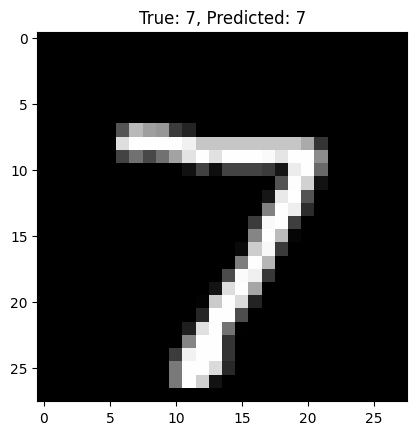

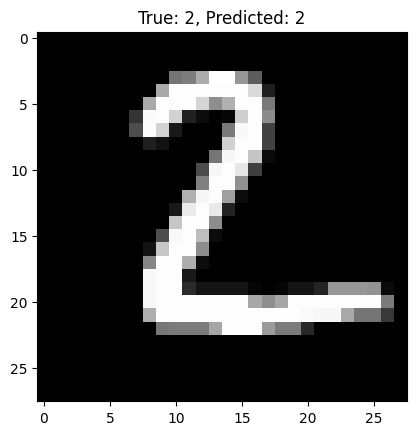

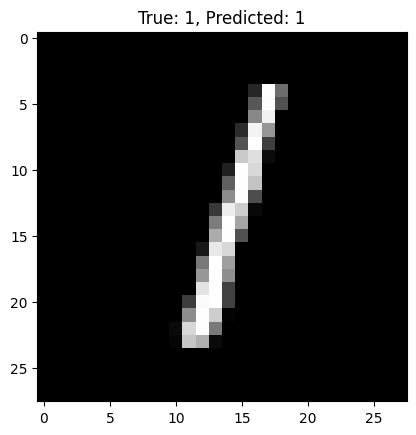

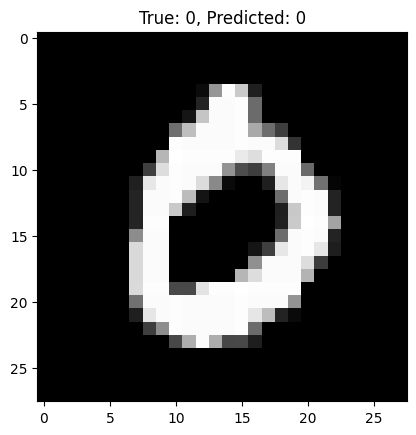

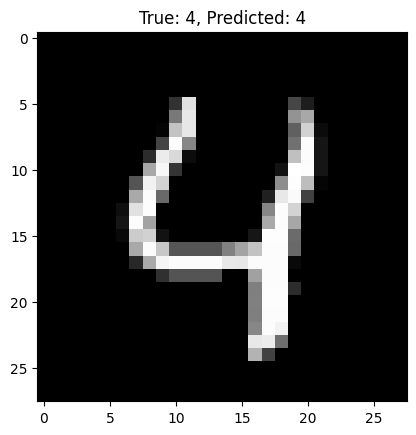

In [12]:
# Get a batch of test data
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Predict
model.eval()
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Visualize the first 5 predictions
for i in range(5):
    plt.imshow(images[i].cpu().squeeze(), cmap='gray')
    plt.title(f"True: {labels[i].item()}, Predicted: {predicted[i].item()}")
    plt.show()

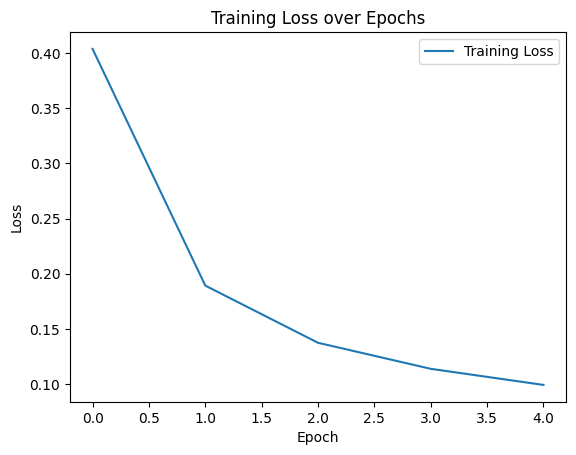

In [13]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 5

# Transformations for MNIST dataset (Normalization to mean=0.5, std=0.5)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='/tmp/mnist_data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='/tmp/mnist_data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Define the CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)  # 1 input channel (grayscale), 32 filters
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)  # 64 filters
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # 64 channels * 7x7 spatial dimensions
        self.fc2 = nn.Linear(128, 10)  # 10 output classes (digits 0-9)
    
    def forward(self, x):
        x = self.conv1(x)  # First convolutional layer
        x = F.relu(x)  # Apply ReLU activation
        x = self.pool(x)  # Max pooling
        x = self.conv2(x)  # Second convolutional layer
        x = F.relu(x)  # Apply ReLU activation
        x = self.pool(x)  # Max pooling
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)  # First fully connected layer
        x = F.relu(x)  # Apply ReLU activation
        x = self.fc2(x)  # Output layer
        return x

# Instantiate the model
model = CNN().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)  # Move data to device
        optimizer.zero_grad()  # Zero the gradients
        output = model(data)  # Forward pass
        loss = criterion(output, target)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluating the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output, 1)  # Get the class with the highest score
        correct += (predicted == target).sum().item()
        total += target.size(0)

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Epoch [1/5], Loss: 0.0020
Epoch [2/5], Loss: 0.0083
Epoch [3/5], Loss: 0.0134
Epoch [4/5], Loss: 0.0025
Epoch [5/5], Loss: 0.1346
Test Accuracy: 98.66%


In [24]:
import torch
import torch.nn as nn

# BatchNorm for a 4D tensor [batch_size, channels, height, width]
batch_norm = nn.BatchNorm2d(num_features=3)  # Assume 3 feature channels
x = torch.randn(8, 3, 32, 32)  # Batch of 8 images, 3 channels, 32x32 resolution
batch_norm(x).shape

torch.Size([8, 3, 32, 32])

In [27]:
layer_norm = nn.LayerNorm([10])  # Normalize across 10 features
x = torch.randn(4, 10)  # 4 data points, each with 10 features
layer_norm(x)

tensor([[-0.6540,  0.0459, -0.3035, -1.1432,  0.5607, -0.8721, -0.8880,  0.7543,
          2.3932,  0.1067],
        [ 1.0065, -2.4355,  0.0358,  0.3803,  0.0575,  1.4417, -0.4384,  0.1990,
          0.4082, -0.6551],
        [ 0.2172,  0.1317,  0.7018, -2.1580,  0.2177,  1.2543,  1.0994,  0.4165,
         -0.8543, -1.0262],
        [ 1.6099, -1.2354,  1.3955, -0.9515,  0.9861, -0.2067, -0.8856, -1.0571,
          0.0102,  0.3345]], grad_fn=<NativeLayerNormBackward0>)

In [29]:
instance_norm = nn.InstanceNorm2d(num_features=3)  # Normalize 3 channels
x = torch.randn(8, 3, 32, 32)  # Batch of 8 images, 3 channels, 32x32 resolution
instance_norm(x).shape

torch.Size([8, 3, 32, 32])

In [32]:
group_norm = nn.GroupNorm(num_groups=2, num_channels=6)  # Divide 6 channels into 2 groups
x = torch.randn(8, 6, 32, 32)  # Batch of 8 images, 6 channels
group_norm(x)

tensor([[[[-4.2865e-01, -1.2404e+00,  6.0064e-01,  ...,  1.3856e+00,
            6.5478e-01, -3.5222e-01],
          [-2.3045e+00,  1.5596e+00, -7.8120e-01,  ..., -6.6849e-01,
            6.5333e-01,  7.8721e-02],
          [-1.4147e+00, -1.4306e+00, -1.2951e+00,  ...,  6.1227e-01,
           -1.5542e+00, -1.7978e+00],
          ...,
          [ 1.8074e+00, -1.7059e-01, -2.2188e-01,  ...,  1.1006e+00,
           -1.1419e+00, -3.5350e-01],
          [ 9.1426e-02, -1.6862e+00,  4.6726e-01,  ...,  1.0060e+00,
           -2.4887e+00, -1.3789e+00],
          [-1.4021e+00, -3.9735e-02,  4.5189e-01,  ...,  4.2294e-01,
           -1.1042e+00, -2.2568e-01]],

         [[-1.4088e+00, -1.6712e+00,  1.1103e+00,  ...,  4.0107e-01,
            1.3458e+00,  1.5193e-01],
          [ 6.6741e-01,  2.1905e-01, -1.1694e+00,  ..., -3.8756e-01,
            5.8471e-01, -1.7729e+00],
          [-1.8654e-01, -2.8596e-01, -6.4870e-01,  ..., -1.0178e+00,
            7.0742e-01, -1.0945e+00],
          ...,
     

In [33]:
import torch
import torch.nn as nn

# Define a BatchNorm layer
batch_norm = nn.BatchNorm2d(num_features=3)

# Learnable parameters
print("Gamma (scale):", batch_norm.weight)  # Corresponds to γ
print("Beta (shift):", batch_norm.bias)    # Corresponds to β

# Dummy input
x = torch.randn(8, 3, 32, 32)  # Batch of 8, 3 channels, 32x32 resolution

# Forward pass
output = batch_norm(x)

# Backward pass
loss = output.mean()  # Example loss function
loss.backward()

# Gradients for gamma and beta
print("Gamma gradient:", batch_norm.weight.grad)
print("Beta gradient:", batch_norm.bias.grad)

Gamma (scale): Parameter containing:
tensor([1., 1., 1.], requires_grad=True)
Beta (shift): Parameter containing:
tensor([0., 0., 0.], requires_grad=True)
Gamma gradient: tensor([ 1.7388e-10,  6.1109e-10, -1.1665e-09])
Beta gradient: tensor([0.3333, 0.3333, 0.3333])


In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import math
import numpy as np

# Define dummy dataset
class TranslationDataset(Dataset):
    def __init__(self, data, src_vocab, tgt_vocab):
        self.data = data
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        src_sentence, tgt_sentence = self.data[idx]
        src_indices = [self.src_vocab[word] for word in src_sentence.split()]
        tgt_indices = [self.tgt_vocab[word] for word in tgt_sentence.split()]
        return torch.tensor(src_indices), torch.tensor(tgt_indices)

# Define positional encoding
class PositionalEncoding(nn.Module):
    def __init__(self, embed_size, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, embed_size)
        self.encoding.requires_grad = False
        
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        _2i = torch.arange(0, embed_size, step=2).float()
        
        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / embed_size)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / embed_size)))
        
    def forward(self, x):
        seq_len = x.size(1)
        return x + self.encoding[:seq_len, :].to(x.device)

# Define Transformer-based translation model
class TranslationModel(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, embed_size, num_heads, ff_hidden_dim, num_layers, dropout=0.1):
        super(TranslationModel, self).__init__()
        self.src_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, embed_size)
        self.positional_encoding = PositionalEncoding(embed_size)
        
        self.transformer = nn.Transformer(
            d_model=embed_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=ff_hidden_dim,
            dropout=dropout
        )
        
        self.fc_out = nn.Linear(embed_size, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, src, tgt, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask):
        # Embed and add positional encoding
        src_emb = self.dropout(self.positional_encoding(self.src_embedding(src)))
        tgt_emb = self.dropout(self.positional_encoding(self.tgt_embedding(tgt)))
        
        # Pass through the transformer
        transformer_out = self.transformer(
            src_emb.transpose(0, 1), 
            tgt_emb.transpose(0, 1),
            src_mask, tgt_mask,
            src_padding_mask, tgt_padding_mask
        )
        
        # Pass through the output layer
        out = self.fc_out(transformer_out)
        return out

# Utility function to generate masks
def create_mask(src, tgt, src_pad_idx, tgt_pad_idx):
    src_seq_len = src.shape[1]
    tgt_seq_len = tgt.shape[1]
    
    src_mask = torch.zeros((src_seq_len, src_seq_len)).type(torch.bool)
    tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_seq_len).type(torch.bool)
    
    src_padding_mask = (src == src_pad_idx)
    tgt_padding_mask = (tgt == tgt_pad_idx)
    
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

# Example data
src_vocab = {"<pad>": 0, "hello": 1, "world": 2}
tgt_vocab = {"<pad>": 0, "bonjour": 1, "monde": 2}
data = [("hello world", "bonjour monde")]

# Create dataset and dataloader
dataset = TranslationDataset(data, src_vocab, tgt_vocab)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Hyperparameters
SRC_VOCAB_SIZE = len(src_vocab)
TGT_VOCAB_SIZE = len(tgt_vocab)
EMBED_SIZE = 128
NUM_HEADS = 4
FF_HIDDEN_DIM = 512
NUM_LAYERS = 2
DROPOUT = 0.1
PAD_IDX = src_vocab["<pad>"]

# Initialize model, loss, and optimizer
model = TranslationModel(SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, EMBED_SIZE, NUM_HEADS, FF_HIDDEN_DIM, NUM_LAYERS, DROPOUT)
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(10):
    model.train()
    for src, tgt in dataloader:
        src = src.to(torch.long)
        tgt = tgt.to(torch.long)
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]
        
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input, PAD_IDX, PAD_IDX)
        
        preds = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
        preds = preds.transpose(0, 1)  # (seq_len, batch_size, vocab_size) -> (batch_size, seq_len, vocab_size)
        
        loss = loss_fn(preds.reshape(-1, preds.shape[-1]), tgt_output.reshape(-1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

/Users/sajjadedalatzadeh/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


AssertionError: expecting key_padding_mask shape of (1, 2), but got torch.Size([1, 1])

In [ ]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class LitModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # Define the model architecture
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('train_loss', loss)  # Log metrics
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = F.cross_entropy(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log('val_loss', val_loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        test_loss = F.cross_entropy(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log('test_loss', test_loss)
        self.log('test_acc', acc)

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-3)

In [11]:
import ray
from ray.train.torch import TorchTrainer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# Define the model
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(10, 10)

    def forward(self, x):
        return F.relu(self.fc1(x))

# Define the training function
def train_fn():
    # Setup data
    data = torch.randn(100, 10)
    target = torch.randn(100, 10)
    dataset = TensorDataset(data, target)
    train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Setup model and optimizer
    model = SimpleModel()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    # Training loop
    for epoch in range(10):
        model.train()
        for batch_data, batch_target in train_loader:
            optimizer.zero_grad()
            output = model(batch_data)
            loss = criterion(output, batch_target)
            loss.backward()
            optimizer.step()
        
        print(f"Epoch {epoch}, Loss {loss.item()}")

# Initialize Ray
ray.init(ignore_reinit_error=True)

# Create a Trainer
trainer = TorchTrainer(train_fn)

# Run distributed training
trainer.fit()

# Shutdown Ray
ray.shutdown()

2024-11-23 20:57:42,902	INFO worker.py:1819 -- Started a local Ray instance.
2024-11-23 20:57:43,496	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


== Status ==
Current time: 2024-11-23 20:57:43 (running for 00:00:00.11)
Using FIFO scheduling algorithm.
Logical resource usage: 2.0/8 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-11-23_20-57-42_121076_55783/artifacts/2024-11-23_20-57-43/TorchTrainer_2024-11-23_20-57-43/driver_artifacts
Number of trials: 1/1 (1 PENDING)




(raylet) /Users/sajjadedalatzadeh/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
(raylet)   warnings.warn(
(TorchTrainer pid=56826) Started distributed worker processes: 
(TorchTrainer pid=56826) - (node_id=e4868dc89682cab81c946333da39db2a493fb52c1ebb05fd13dd457e, ip=127.0.0.1, pid=56836) world_rank=0, local_rank=0, node_rank=0
(RayTrainWorker pid=56836) Setting up process group for: env:// [rank=0, world_size=1]


(RayTrainWorker pid=56836) Epoch 0, Loss 0.8983022570610046
(RayTrainWorker pid=56836) Epoch 1, Loss 1.3154127597808838
(RayTrainWorker pid=56836) Epoch 2, Loss 1.163907766342163
(RayTrainWorker pid=56836) Epoch 3, Loss 0.8860348463058472
(RayTrainWorker pid=56836) Epoch 4, Loss 0.992579460144043
(RayTrainWorker pid=56836) Epoch 5, Loss 0.9649050831794739
(RayTrainWorker pid=56836) Epoch 6, Loss 0.7659894824028015
(RayTrainWorker pid=56836) Epoch 7, Loss 0.9999068975448608
(RayTrainWorker pid=56836) Epoch 8, Loss 0.8978530168533325
(RayTrainWorker pid=56836) Epoch 9, Loss 0.9096078872680664
== Status ==
Current time: 2024-11-23 20:57:48 (running for 00:00:05.17)
Using FIFO scheduling algorithm.
Logical resource usage: 2.0/8 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-11-23_20-57-42_121076_55783/artifacts/2024-11-23_20-57-43/TorchTrainer_2024-11-23_20-57-43/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




2024-11-23 20:57:49,274	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/sajjadedalatzadeh/ray_results/TorchTrainer_2024-11-23_20-57-43' in 0.0027s.
2024-11-23 20:57:49,276	INFO tune.py:1041 -- Total run time: 5.78 seconds (5.77 seconds for the tuning loop).


Trial TorchTrainer_7e76d_00000 completed. Last result: 
== Status ==
Current time: 2024-11-23 20:57:49 (running for 00:00:05.77)
Using FIFO scheduling algorithm.
Logical resource usage: 2.0/8 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-11-23_20-57-42_121076_55783/artifacts/2024-11-23_20-57-43/TorchTrainer_2024-11-23_20-57-43/driver_artifacts
Number of trials: 1/1 (1 TERMINATED)




(raylet) /Users/sajjadedalatzadeh/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020 [repeated 3x across cluster]
(raylet)   warnings.warn( [repeated 3x across cluster]
